In [1]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import warnings
import json
import re
from tabpfn import TabPFNClassifier

# TabPFN Extensions for SHAP-based feature importance
try:
    from tabpfn_extensions import interpretability
    TABPFN_EXTENSIONS_AVAILABLE = True
except ImportError:
    print("WARNING: tabpfn_extensions not installed. SHAP-based feature importance disabled.")
    print("Install with: pip install tabpfn-extensions")
    TABPFN_EXTENSIONS_AVAILABLE = False

warnings.filterwarnings('ignore')

# Utility functions from document 1
def _slug(s):
    return re.sub(r"[^-a-zA-Z0-9_.]+", "_", str(s)).strip("_")

def assert_no_well_leak(dev_df, train_mask, test_mask):
    wells_train = set(dev_df.loc[train_mask, "Plate_Well"])
    wells_test = set(dev_df.loc[test_mask, "Plate_Well"])
    overlap_w = wells_train & wells_test
    if overlap_w:
        raise RuntimeError(f"Leak: wells appear in both splits: {sorted(overlap_w)[:10]}")
    
    if "Group_ID" in dev_df.columns:
        gtrain = set(zip(dev_df.loc[train_mask, "Plate_Well"], dev_df.loc[train_mask, "Group_ID"]))
        gtest = set(zip(dev_df.loc[test_mask, "Plate_Well"], dev_df.loc[test_mask, "Group_ID"]))
        gover = gtrain & gtest
        if gover:
            raise RuntimeError(f"Leak: (Plate_Well, Group_ID) in both splits: {list(sorted(gover))[:5]}")
    
    both = (train_mask & test_mask)
    if both.any():
        raise RuntimeError("Rows marked train and test simultaneously")
    
    print(f"No leakage: {len(wells_train)} train wells, {len(wells_test)} test wells")

def auc(y_true, y_prob):
    from sklearn.metrics import roc_auc_score
    return roc_auc_score(y_true, y_prob)

In [2]:
def save_prob_density_log(probs_dict, mean_prob, out_path, title):
    from scipy.stats import gaussian_kde
    x_grid = np.linspace(0, 1, 200)
    plt.figure(figsize=(7, 5))
    for label, arr, color in probs_dict:
        if len(arr) > 1:
            kde = gaussian_kde(arr)
            plt.plot(x_grid, kde(x_grid), label=label)
    plt.axvline(mean_prob, linestyle="--", alpha=0.8, label=f"Drug mean = {mean_prob:.3f}")
    plt.yscale("log")
    plt.xlabel("P(Control)"); plt.ylabel("Density (log)"); plt.title(title); plt.legend()
    plt.tight_layout(); plt.savefig(out_path, dpi=300, bbox_inches="tight"); plt.close()

def save_prob_density_linear(probs_dict, mean_prob, out_path, title):
    from scipy.stats import gaussian_kde
    x_grid = np.linspace(0, 1, 200)
    plt.figure(figsize=(7, 5))
    for label, arr, color in probs_dict:
        if len(arr) > 1:
            kde = gaussian_kde(arr)
            plt.plot(x_grid, kde(x_grid), label=label)
    plt.axvline(mean_prob, linestyle="--", alpha=0.8, label=f"Drug mean = {mean_prob:.3f}")
    plt.xlabel("P(Control)"); plt.ylabel("Density"); plt.title(title); plt.legend()
    plt.tight_layout(); plt.savefig(out_path, dpi=300, bbox_inches="tight"); plt.close()

def save_cm(y_true, y_pred, out_path, title):
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    plt.figure(figsize=(5.5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Pred: Control','Pred: Patient'],
                yticklabels=['True: Control','True: Patient'])
    plt.title(title); plt.tight_layout(); plt.savefig(out_path, dpi=300, bbox_inches="tight"); plt.close()

# ==================== QUALITY CONTROL FUNCTIONS ====================

def calculate_qc_metrics(neuron_counts):
    """Calculate comprehensive QC metrics for well filtering"""
    metrics = {
        'mean': np.mean(neuron_counts),
        'median': np.median(neuron_counts),
        'std': np.std(neuron_counts),
        'mad': np.median(np.abs(neuron_counts - np.median(neuron_counts))),
        'q1': np.percentile(neuron_counts, 25),
        'q3': np.percentile(neuron_counts, 75),
        'iqr': np.percentile(neuron_counts, 75) - np.percentile(neuron_counts, 25),
        'min': np.min(neuron_counts),
        'max': np.max(neuron_counts),
    }
    return metrics

def filter_wells_by_mad(neuron_counts, threshold_mad=3.0):
    """Filter wells using Median Absolute Deviation (MAD)"""
    median = np.median(neuron_counts)
    mad = np.median(np.abs(neuron_counts - median))
    
    # Handle case where MAD is 0
    if mad == 0:
        mad = 1.4826 * np.std(neuron_counts)  # Use robust std estimate
    
    # Calculate modified Z-score
    modified_z_scores = 0.6745 * (neuron_counts - median) / mad
    
    # Keep wells within threshold
    good_wells_mask = np.abs(modified_z_scores) <= threshold_mad
    return good_wells_mask

def apply_rigorous_qc(df, threshold=2.0, min_neurons_per_well=0, 
                      per_plate=True, plate_column='Plate_full', plot_dir=None):
    """
    Apply rigorous quality control to filter wells using MAD method
    
    Parameters:
    -----------
    df : DataFrame with 'Plate_Well' column
    threshold : float, MAD threshold for filtering
    min_neurons_per_well : int, minimum number of neurons per well (applied first)
                          Set to 0 to disable minimum threshold
    per_plate : bool, if True apply QC per-plate (recommended), if False apply globally
    plate_column : str, column name for plate identifier (used if per_plate=True)
    plot_dir : Path to save QC plots
    
    Returns:
    --------
    filtered_df : DataFrame with filtered wells
    qc_report : dict with QC statistics
    """
    # Calculate neuron counts per well with plate information
    if per_plate and plate_column in df.columns:
        well_plate_counts = df.groupby(["Plate_Well", plate_column]).size().reset_index(name='count')
        well_plate_counts['well'] = well_plate_counts['Plate_Well']
        well_plate_counts['plate'] = well_plate_counts[plate_column]
    else:
        well_counts = df.groupby("Plate_Well").size()
        wells = well_counts.index
        counts = well_counts.values
        per_plate = False  # Force global if plate column not available
    
    # Using MAD method
    method_name = f"MAD (threshold={threshold})"
    
    if per_plate:
        # Per-plate QC
        all_good_wells = []
        wells_filtered_by_min = 0
        wells_filtered_by_statistical = 0
        plate_qc_details = []
        
        for plate in well_plate_counts['plate'].unique():
            plate_data = well_plate_counts[well_plate_counts['plate'] == plate]
            wells_in_plate = plate_data['well'].values
            counts_in_plate = plate_data['count'].values
            
            # Stage 1: Minimum threshold
            if min_neurons_per_well > 0:
                min_mask = counts_in_plate >= min_neurons_per_well
                wells_after_min = wells_in_plate[min_mask]
                counts_after_min = counts_in_plate[min_mask]
                wells_filtered_by_min += (~min_mask).sum()
            else:
                wells_after_min = wells_in_plate
                counts_after_min = counts_in_plate
            
            # Stage 2: Statistical outlier detection using MAD (per plate)
            if len(counts_after_min) > 3:  # Need at least 4 wells for meaningful statistics
                good_mask_stat = filter_wells_by_mad(counts_after_min, threshold_mad=threshold)
                good_wells_in_plate = wells_after_min[good_mask_stat]
                wells_filtered_by_statistical += (~good_mask_stat).sum()
            else:
                good_wells_in_plate = wells_after_min
            
            all_good_wells.extend(good_wells_in_plate)
            
            # Track per-plate QC
            plate_qc_details.append({
                'plate': plate,
                'total': len(wells_in_plate),
                'kept': len(good_wells_in_plate),
                'filtered_min': (~min_mask).sum() if min_neurons_per_well > 0 else 0,
                'filtered_stat': len(wells_after_min) - len(good_wells_in_plate),
                'mean_before': np.mean(counts_in_plate),
                'mean_after': np.mean(counts_in_plate[[w in good_wells_in_plate for w in wells_in_plate]]),
            })
        
        filtered_df = df[df["Plate_Well"].isin(all_good_wells)].copy()
        
        # Calculate overall metrics
        well_counts = df.groupby("Plate_Well").size()
        wells = well_counts.index
        counts = well_counts.values
        metrics_original = calculate_qc_metrics(counts)
        
        final_counts = well_counts[well_counts.index.isin(all_good_wells)].values
        metrics_after = calculate_qc_metrics(final_counts)
        
        # For plotting, get wells_after_min and good_mask_statistical globally
        if min_neurons_per_well > 0:
            min_threshold_mask = counts >= min_neurons_per_well
            counts_after_min = counts[min_threshold_mask]
            wells_after_min = wells[min_threshold_mask]
        else:
            min_threshold_mask = np.ones(len(counts), dtype=bool)
            counts_after_min = counts
            wells_after_min = wells
        
        good_mask_statistical = np.array([w in all_good_wells for w in wells_after_min])
        
    else:
        # Global QC (original logic)
        wells = well_counts.index
        counts = well_counts.values
        
        # Apply minimum threshold first (if specified)
        if min_neurons_per_well > 0:
            min_threshold_mask = counts >= min_neurons_per_well
            counts_after_min = counts[min_threshold_mask]
            wells_after_min = wells[min_threshold_mask]
            wells_filtered_by_min = len(wells) - len(wells_after_min)
        else:
            min_threshold_mask = np.ones(len(counts), dtype=bool)
            counts_after_min = counts
            wells_after_min = wells
            wells_filtered_by_min = 0
        
        # Calculate QC metrics on original data
        metrics_original = calculate_qc_metrics(counts)
    
        # Apply MAD statistical filtering on data after minimum threshold  
        good_mask_statistical = filter_wells_by_mad(counts_after_min, threshold_mad=threshold)
        
        # Get final good wells (passed both filters)
        good_wells_after_statistical = wells_after_min[good_mask_statistical]
        filtered_df = df[df["Plate_Well"].isin(good_wells_after_statistical)].copy()
        
        wells_filtered_by_statistical = len(wells_after_min) - len(good_wells_after_statistical)
        total_wells_filtered = wells_filtered_by_min + wells_filtered_by_statistical
        metrics_after = calculate_qc_metrics(counts_after_min[good_mask_statistical])
        
        plate_qc_details = None  # No per-plate details in global mode
    
    # Add per-plate suffix to method name
    if per_plate:
        method_name = f"{method_name} [PER-PLATE]"
    else:
        method_name = f"{method_name} [GLOBAL]"
    
    # Create QC report with two-stage information
    total_wells_filtered = wells_filtered_by_min + wells_filtered_by_statistical
    qc_report = {
        'method': method_name,
        'per_plate': per_plate,
        'min_neurons_threshold': min_neurons_per_well,
        'total_wells': len(wells),
        'wells_kept': len(all_good_wells) if per_plate else len(good_wells_after_statistical),
        'wells_filtered': total_wells_filtered,
        'wells_filtered_by_min_threshold': wells_filtered_by_min,
        'wells_filtered_by_statistical': wells_filtered_by_statistical,
        'filter_rate': total_wells_filtered / len(wells),
        'metrics_before': metrics_original,
        'metrics_after_min_threshold': calculate_qc_metrics(counts_after_min) if wells_filtered_by_min > 0 else metrics_original,
        'metrics_after': metrics_after,
        'plate_details': plate_qc_details,
    }
    
    # Generate QC plots if requested
    if plot_dir is not None:
        plot_dir = pathlib.Path(plot_dir)
        plot_dir.mkdir(parents=True, exist_ok=True)
        
        # Get final counts after QC
        if per_plate:
            counts_final = well_counts[well_counts.index.isin(all_good_wells)].values
        else:
            counts_final = counts_after_min[good_mask_statistical]
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Distribution before/after
        axes[0, 0].hist(counts, bins=50, alpha=0.7, label='Before QC', edgecolor='black')
        axes[0, 0].hist(counts_final, bins=50, alpha=0.7, label='After QC', edgecolor='black')
        axes[0, 0].axvline(metrics_original['median'], color='red', linestyle='--', label=f"Median: {metrics_original['median']:.0f}")
        axes[0, 0].set_xlabel('Neurons per Well')
        axes[0, 0].set_ylabel('Number of Wells')
        axes[0, 0].set_title(f'Neuron Distribution: {method_name}')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Box plot
        axes[0, 1].boxplot([counts, counts_final], labels=['Before QC', 'After QC'])
        axes[0, 1].set_ylabel('Neurons per Well')
        axes[0, 1].set_title('Box Plot Comparison')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Outlier detection visualization
        well_indices = np.arange(len(counts))
        final_good_mask = np.array([w in (all_good_wells if per_plate else good_wells_after_statistical) for w in wells])
        colors = ['green' if m else 'red' for m in final_good_mask]
        axes[1, 0].scatter(well_indices, counts, c=colors, alpha=0.6)
        axes[1, 0].axhline(metrics_original['median'], color='blue', linestyle='--', label='Median')
        axes[1, 0].axhline(metrics_original['median'] - threshold*metrics_original['mad'], color='orange', linestyle='--', label=f'±{threshold} MAD')
        axes[1, 0].axhline(metrics_original['median'] + threshold*metrics_original['mad'], color='orange', linestyle='--')
        axes[1, 0].set_xlabel('Well Index')
        axes[1, 0].set_ylabel('Neurons per Well')
        axes[1, 0].set_title('MAD Outlier Detection (Green=Keep, Red=Filter)')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Cumulative distribution
        sorted_before = np.sort(counts)
        sorted_after = np.sort(counts_final)
        cumsum_before = np.arange(1, len(sorted_before) + 1) / len(sorted_before) * 100
        cumsum_after = np.arange(1, len(sorted_after) + 1) / len(sorted_after) * 100
        
        axes[1, 1].plot(sorted_before, cumsum_before, label='Before QC', linewidth=2)
        axes[1, 1].plot(sorted_after, cumsum_after, label='After QC', linewidth=2)
        axes[1, 1].set_xlabel('Neurons per Well')
        axes[1, 1].set_ylabel('Cumulative % of Wells')
        axes[1, 1].set_title('Cumulative Distribution')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(plot_dir / 'qc_analysis_mad.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # Save detailed report
        report_text = f"""Quality Control Report (MAD Method)
==========================================
Method: {method_name}
Minimum Neurons Threshold: {qc_report['min_neurons_threshold']} (0 = disabled)

Summary:
--------
Total wells: {qc_report['total_wells']}
Wells kept: {qc_report['wells_kept']}
Wells filtered (total): {qc_report['wells_filtered']}
  - By minimum threshold: {qc_report['wells_filtered_by_min_threshold']}
  - By MAD statistical method: {qc_report['wells_filtered_by_statistical']}
Filter rate: {qc_report['filter_rate']:.2%}

Metrics Before QC:
------------------
Mean: {qc_report['metrics_before']['mean']:.2f}
Median: {qc_report['metrics_before']['median']:.2f}
Std Dev: {qc_report['metrics_before']['std']:.2f}
MAD: {qc_report['metrics_before']['mad']:.2f}
Range: [{qc_report['metrics_before']['min']}, {qc_report['metrics_before']['max']}]

Metrics After QC:
-----------------
Mean: {qc_report['metrics_after']['mean']:.2f}
Median: {qc_report['metrics_after']['median']:.2f}
Std Dev: {qc_report['metrics_after']['std']:.2f}
MAD: {qc_report['metrics_after']['mad']:.2f}
Range: [{qc_report['metrics_after']['min']}, {qc_report['metrics_after']['max']}]
"""
        
        # Add per-plate details if available
        if qc_report['plate_details'] is not None:
            report_text += "\n\nPer-Plate QC Details:\n"
            report_text += "=" * 80 + "\n"
            for plate_info in qc_report['plate_details']:
                filtered_total = plate_info['filtered_min'] + plate_info['filtered_stat']
                filter_rate = filtered_total / plate_info['total'] * 100
                report_text += f"\nPlate: {plate_info['plate']}\n"
                report_text += f"  Total wells: {plate_info['total']}\n"
                report_text += f"  Kept: {plate_info['kept']}\n"
                report_text += f"  Filtered: {filtered_total} ({filter_rate:.1f}%)\n"
                report_text += f"  Mean: {plate_info['mean_before']:.1f} → {plate_info['mean_after']:.1f}\n"
        
        with open(plot_dir / 'qc_report_mad.txt', 'w') as f:
            f.write(report_text)
    
    return filtered_df, qc_report

# ==================== FEATURE IMPORTANCE FUNCTIONS ====================

def calculate_shap_importance(model, X, y, feature_names, n_samples=100):
    """
    Calculate SHAP-based feature importance using TabPFN extensions
    
    Parameters:
    -----------
    model : trained TabPFN model
    X : feature matrix
    y : labels
    feature_names : list of feature names
    n_samples : number of samples to use for SHAP calculation
    
    Returns:
    --------
    shap_values : SHAP values object
    importance_df : DataFrame with feature importance scores
    """
    if not TABPFN_EXTENSIONS_AVAILABLE:
        print("WARNING: tabpfn_extensions not available. SHAP importance disabled.")
        return None, None
    
    try:
        print(f"Calculating SHAP values for {n_samples} samples...")
        print("WARNING: This may run slowly on CPU-only systems.")
        
        # Calculate SHAP values using permutation algorithm
        shap_values = interpretability.shap.get_shap_values(
            estimator=model,
            test_x=X[:n_samples],
            attribute_names=feature_names,
            algorithm="permutation",
        )
        
        # Calculate mean absolute SHAP values for each feature
        mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
        
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'shap_importance': mean_abs_shap,
        }).sort_values('shap_importance', ascending=False)
        
        print(f"SHAP calculation complete!")
        return shap_values, importance_df
        
    except Exception as e:
        print(f"SHAP calculation failed: {e}")
        return None, None

def save_shap_plots(shap_values, out_path, title="SHAP Feature Importance"):
    """Save SHAP visualization plots"""
    if shap_values is None:
        return
    
    try:
        # Create SHAP summary plot
        fig = interpretability.shap.plot_shap(shap_values)
        if fig is not None:
            fig.suptitle(title, fontsize=14, y=0.98)
            fig.savefig(out_path, dpi=300, bbox_inches='tight')
            plt.close(fig)
            print(f"SHAP plot saved to: {out_path}")
    except Exception as e:
        print(f"Failed to save SHAP plot: {e}")

print("Simplified utility functions loaded successfully!")

Simplified utility functions loaded successfully!


In [3]:
# Configuration
# Quality Control Parameters (using MAD method only)
qc_threshold = 2.0  # MAD threshold for outlier detection
min_neurons_per_well = 0  # Minimum neurons per well (set to 0 to disable)
qc_per_plate = True  # TRUE = Apply QC per-plate (RECOMMENDED to handle batch effects)

random_seed = 42
test_group_sizes = [50, 60, 70, 80, 90, 100]

data_dir = pathlib.Path(r"D:\pycytominer\microsam_features").resolve(strict=True)
design_dir = data_dir / "design"
results_dir = pathlib.Path("D:/tabPFN")
results_dir.mkdir(parents=True, exist_ok=True)

neurite_features = [
    "N_node","Soma_surface","N_stem","Number_of_Nodes","Soma_Surface","Number_of_Stems",
    "Number_of_Bifurcations","Number_of_Branches","Number_of_Tips","Overall_Width",
    "Overall_Height","Average_Diameter","Total_Length","Total_Surface","Total_Volume",
    "Max_Euclidean_Distance","Max_Path_Distance","Max_Branch_Order","Average_Contraction",
    "Average_Fragmentation","Average_PD_Ratio","Avg_Bif_Angle_Local","Avg_Bif_Angle_Remote",
    "Hausdorff_Dimension",
]
metadata_cols = ["SampleID", "Genotype", "Seeding_density", "Treatment", "BatchID"]

def plate_token_from_filename(fname: str) -> str:
    parts = fname.split("_")
    if len(parts) >= 2 and parts[1].startswith("BA"):
        return parts[1]
    m = re.search(r'BA\d+Q\d+[AB]', fname)
    return m.group(0) if m else parts[1]

def plate_base_from_plate_full(plate_full: str) -> str:
    return re.sub(r'[AB]$', '', str(plate_full))

In [4]:
print("\n=== Loading Drug Screening Data ===")

feature_files = [
    "Xu_BA071Q1A_R_annotate_file.csv", "Xu_BA071Q1B_annotate_file.csv",
    "Xu_BA071Q2A_annotate_file.csv", "Xu_BA071Q2B_annotate_file.csv",
    "Xu_BA071Q3A_annotate_file.csv", "Xu_BA071Q3B_annotate_file.csv",
    "Xu_BA071Q4A_annotate_file.csv", "Xu_BA071Q4B_annotate_file.csv",
]

design_files = [
    "6-26-2024_plate1_design.csv", "6-26-2024_plate2_design.csv",
    "6-26-2024_plate3_design.csv", "6-26-2024_plate4_design.csv",
]

# Load design files
design_df = pd.concat([pd.read_csv(design_dir / f, dtype=str) for f in design_files], ignore_index=True)

# Fix BatchID typo if present
if "BacthID" in design_df.columns and "BatchID" not in design_df.columns:
    design_df = design_df.rename(columns={"BacthID": "BatchID"})

# Standardize columns
for c in ["Plate_ID","Well_ID","Row","Col"] + metadata_cols:
    if c in design_df.columns:
        design_df[c] = design_df[c].astype(str).str.strip()
design_df["Well_ID"] = design_df["Well_ID"].str.upper()

# Load feature files
frames = []
for fname in feature_files:
    fdf = pd.read_csv(data_dir / fname, dtype=str)
    fdf["__source_file"] = fname
    
    # Find well column
    well_col = None
    for cand in ["WellID", "Well_Id", "Well_ID", "Well", "well", "Well Name"]:
        if cand in fdf.columns:
            well_col = cand
            break
    if well_col is None:
        raise KeyError(f"No well column in {fname}")
    
    plate_full = plate_token_from_filename(fname)
    plate_base = plate_base_from_plate_full(plate_full)
    
    fdf["Plate_full"] = plate_full
    fdf["Plate_base"] = plate_base
    fdf["WellID"] = fdf[well_col].astype(str).str.upper().str.strip()
    fdf["Plate_Well"] = fdf["Plate_full"] + "_" + fdf["WellID"]
    
    merged = fdf.merge(design_df, how="left", 
                       left_on=["Plate_base", "WellID"],
                       right_on=["Plate_ID", "Well_ID"],
                       suffixes=("", "_design"))
    frames.append(merged)

df_drug = pd.concat(frames, ignore_index=True)

# Cast features
feat_cols = [c for c in neurite_features if c in df_drug.columns]
df_drug[feat_cols] = df_drug[feat_cols].apply(pd.to_numeric, errors="coerce")

# NOTE: Removing hard-coded min_neurites filter to let statistical QC handle filtering
# The statistical QC in Cell 5 will do rigorous outlier detection
# If you want a minimum threshold, it's now handled in the QC function

print(f"Drug screening data shape (before QC): {df_drug.shape}")
print(f"Total wells (before QC): {df_drug['Plate_Well'].nunique()}")


=== Loading Drug Screening Data ===
Drug screening data shape (before QC): (248221, 41)
Total wells (before QC): 768


In [5]:
print("\n=== Loading Additional QR19_QR23 Dataset ===")

# Load QR19_QR23 feature file
qr_feature_file = pathlib.Path(r"D:\tabPFN\microsam_features\3-13-2025_QR19_QR23_annotate_file.csv")
qr_design_file = pathlib.Path(r"D:\tabPFN\microsam_features\design\3-13-2025_design.csv")

qr_features = pd.read_csv(qr_feature_file, dtype=str)
qr_design = pd.read_csv(qr_design_file, dtype=str)

# Standardize design table
for c in ["Plate_ID", "Well_ID", "SampleID", "Genotype", "Row", "Col"]:
    if c in qr_design.columns:
        qr_design[c] = qr_design[c].astype(str).str.strip()
qr_design["Well_ID"] = qr_design["Well_ID"].str.upper()

# Find well column in features
well_col = None
for cand in ["WellID", "Well_Id", "Well_ID", "Well", "well", "Well Name"]:
    if cand in qr_features.columns:
        well_col = cand
        break
if well_col is None:
    raise KeyError("No well column in QR19_QR23 file")

# Process QR features
qr_features["Plate_full"] = "QR19_QR23"
qr_features["Plate_base"] = "QR19_QR23"
qr_features["WellID"] = qr_features[well_col].astype(str).str.upper().str.strip()
qr_features["Plate_Well"] = qr_features["Plate_full"] + "_" + qr_features["WellID"]

# Merge with design
qr_merged = qr_features.merge(qr_design, how="left",
                               left_on="WellID", right_on="Well_ID",
                               suffixes=("", "_design"))

# Add standard columns
qr_merged["Treatment"] = "0.05% DMSO"  # Mark as DMSO for consistency
qr_merged["BatchID"] = "QR_Batch"

# Cast features
qr_merged[feat_cols] = qr_merged[feat_cols].apply(pd.to_numeric, errors="coerce")

# NOTE: Removing hard-coded min_neurites filter to let statistical QC handle filtering
df_qr = qr_merged.copy()

print(f"QR19_QR23 data shape (before QC): {df_qr.shape}")
print(f"Total QR wells (before QC): {df_qr['Plate_Well'].nunique()}")
print(f"QR Genotype distribution:\n{df_qr['Genotype'].value_counts()}")


=== Loading Additional QR19_QR23 Dataset ===
QR19_QR23 data shape (before QC): (41293, 42)
Total QR wells (before QC): 80
QR Genotype distribution:
Genotype
control    23806
patient    17487
Name: count, dtype: int64



=== Rigorous Quality Control Analysis ===
Combined data before QC: (289514, 44)

Drug Screening Data (8 plates):
  Total wells: 768
  Mean neurons/well: 323.2
  Median neurons/well: 375.5
  Min neurons/well: 1
  Max neurons/well: 765
  25th percentile: 148.8
  75th percentile: 461.2

QR19_QR23 Data:
  Total wells: 80
  Mean neurons/well: 516.2
  Median neurons/well: 537.5
  Min neurons/well: 109
  Max neurons/well: 945
  25th percentile: 377.0
  75th percentile: 670.0


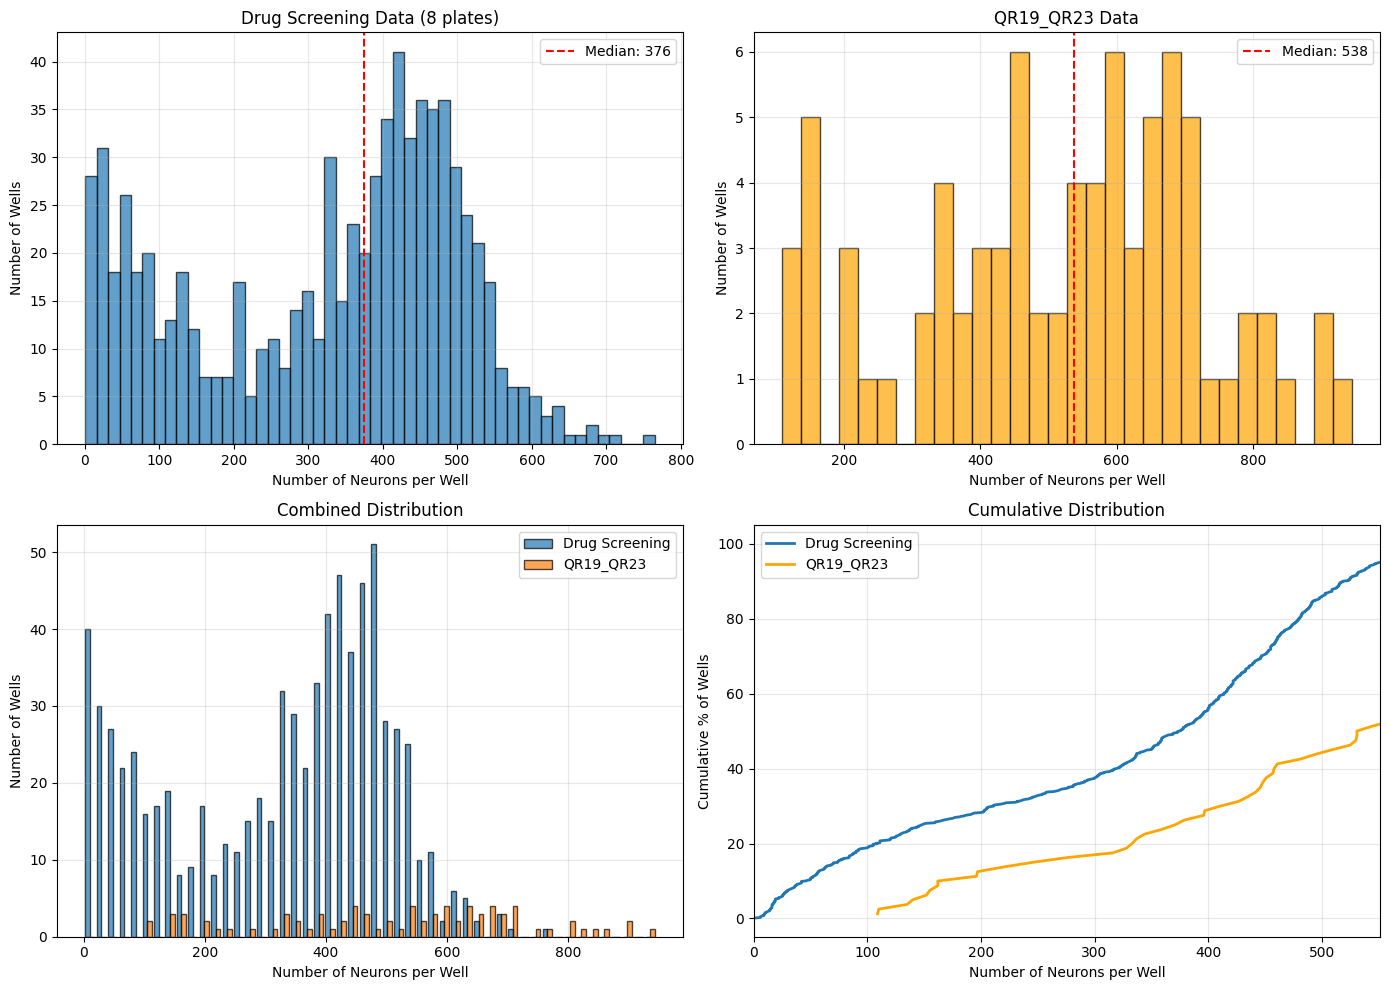


=== Impact of Different Thresholds ===
Threshold    Drug Wells Kept    QR Wells Kept    Total Wells 
----------------------------------------------------------------------
50           689                80               769         
75           651                80               731         
100          624                80               704         
125          602                78               680         
150          575                76               651         
200          552                70               622         

=== Distribution by Plate ===
BA071Q1A: 96 wells total, 96 wells ≥ 0 neurons (mean: 299.6, median: 344.0)
BA071Q1B: 96 wells total, 96 wells ≥ 0 neurons (mean: 326.9, median: 365.5)
BA071Q2A: 96 wells total, 96 wells ≥ 0 neurons (mean: 396.9, median: 465.5)
BA071Q2B: 96 wells total, 96 wells ≥ 0 neurons (mean: 351.6, median: 421.0)
BA071Q3A: 96 wells total, 96 wells ≥ 0 neurons (mean: 244.1, median: 292.5)
BA071Q3B: 96 wells total, 96 wells ≥ 0 neuro

In [6]:
print("\n=== Rigorous Quality Control Analysis ===")

# Combine all data for unified QC
df_all = pd.concat([df_drug, df_qr], ignore_index=True)
print(f"Combined data before QC: {df_all.shape}")

# Count neurons per well for both datasets
drug_neuron_counts = df_drug.groupby("Plate_Well").size()
qr_neuron_counts = df_qr.groupby("Plate_Well").size()

# Statistics
print("\nDrug Screening Data (8 plates):")
print(f"  Total wells: {len(drug_neuron_counts)}")
print(f"  Mean neurons/well: {drug_neuron_counts.mean():.1f}")
print(f"  Median neurons/well: {drug_neuron_counts.median():.1f}")
print(f"  Min neurons/well: {drug_neuron_counts.min()}")
print(f"  Max neurons/well: {drug_neuron_counts.max()}")
print(f"  25th percentile: {drug_neuron_counts.quantile(0.25):.1f}")
print(f"  75th percentile: {drug_neuron_counts.quantile(0.75):.1f}")

print("\nQR19_QR23 Data:")
print(f"  Total wells: {len(qr_neuron_counts)}")
print(f"  Mean neurons/well: {qr_neuron_counts.mean():.1f}")
print(f"  Median neurons/well: {qr_neuron_counts.median():.1f}")
print(f"  Min neurons/well: {qr_neuron_counts.min()}")
print(f"  Max neurons/well: {qr_neuron_counts.max()}")
print(f"  25th percentile: {qr_neuron_counts.quantile(0.25):.1f}")
print(f"  75th percentile: {qr_neuron_counts.quantile(0.75):.1f}")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Drug screening histogram
axes[0, 0].hist(drug_neuron_counts, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(drug_neuron_counts.median(), color='red', linestyle='--', 
                   label=f'Median: {drug_neuron_counts.median():.0f}')
# axes[0, 0].axvline(min_neurites, color='green', linestyle='--', 
#                    label=f'Current threshold: {min_neurites}')
axes[0, 0].set_xlabel('Number of Neurons per Well')
axes[0, 0].set_ylabel('Number of Wells')
axes[0, 0].set_title('Drug Screening Data (8 plates)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# QR histogram
axes[0, 1].hist(qr_neuron_counts, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].axvline(qr_neuron_counts.median(), color='red', linestyle='--', 
                   label=f'Median: {qr_neuron_counts.median():.0f}')
# axes[0, 1].axvline(min_neurites, color='green', linestyle='--', 
#                    label=f'Current threshold: {min_neurites}')
axes[0, 1].set_xlabel('Number of Neurons per Well')
axes[0, 1].set_ylabel('Number of Wells')
axes[0, 1].set_title('QR19_QR23 Data')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Combined histogram
all_counts = pd.concat([
    pd.Series(drug_neuron_counts, name='count').to_frame().assign(dataset='Drug Screening'),
    pd.Series(qr_neuron_counts, name='count').to_frame().assign(dataset='QR19_QR23')
])
axes[1, 0].hist([drug_neuron_counts, qr_neuron_counts], bins=50, 
                label=['Drug Screening', 'QR19_QR23'], alpha=0.7, edgecolor='black')
# axes[1, 0].axvline(min_neurites, color='green', linestyle='--', 
#                    label=f'Current threshold: {min_neurites}', linewidth=2)
axes[1, 0].set_xlabel('Number of Neurons per Well')
axes[1, 0].set_ylabel('Number of Wells')
axes[1, 0].set_title('Combined Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Cumulative distribution
drug_sorted = np.sort(drug_neuron_counts)
qr_sorted = np.sort(qr_neuron_counts)
drug_cumsum = np.arange(1, len(drug_sorted) + 1) / len(drug_sorted) * 100
qr_cumsum = np.arange(1, len(qr_sorted) + 1) / len(qr_sorted) * 100

axes[1, 1].plot(drug_sorted, drug_cumsum, label='Drug Screening', linewidth=2)
axes[1, 1].plot(qr_sorted, qr_cumsum, label='QR19_QR23', linewidth=2, color='orange')
# axes[1, 1].axvline(min_neurites, color='green', linestyle='--', 
#                    label=f'Current threshold: {min_neurites}', linewidth=2)
axes[1, 1].set_xlabel('Number of Neurons per Well')
axes[1, 1].set_ylabel('Cumulative % of Wells')
axes[1, 1].set_title('Cumulative Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, min(drug_neuron_counts.quantile(0.95), qr_neuron_counts.quantile(0.95)))

plt.tight_layout()
plt.savefig(results_dir / 'neuron_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Show wells that would be filtered at different thresholds
print("\n=== Impact of Different Thresholds ===")
thresholds = [50, 75, 100, 125, 150, 200]
print(f"{'Threshold':<12} {'Drug Wells Kept':<18} {'QR Wells Kept':<16} {'Total Wells':<12}")
print("-" * 70)
for threshold in thresholds:
    drug_kept = (drug_neuron_counts >= threshold).sum()
    qr_kept = (qr_neuron_counts >= threshold).sum()
    total_kept = drug_kept + qr_kept
    print(f"{threshold:<12} {drug_kept:<18} {qr_kept:<16} {total_kept:<12}")

min_neurites = 0

print("\n=== Distribution by Plate ===")
# Break down by plate for drug screening data
for plate in df_drug['Plate_full'].unique():
    plate_counts = df_drug[df_drug['Plate_full'] == plate].groupby('Plate_Well').size()
    kept = (plate_counts >= min_neurites).sum()
    print(f"{plate}: {len(plate_counts)} wells total, {kept} wells ≥ {min_neurites} neurons "
          f"(mean: {plate_counts.mean():.1f}, median: {plate_counts.median():.1f})")

# ==================== Apply Rigorous QC ====================
print("\n" + "="*70)
print("APPLYING QUALITY CONTROL (MAD METHOD)")
print("="*70)

# Create QC directory
qc_dir = results_dir / "quality_control"
qc_dir.mkdir(parents=True, exist_ok=True)

# Apply MAD QC method
df_all_qc, final_qc_report = apply_rigorous_qc(
    df_all,
    threshold=qc_threshold,
    min_neurons_per_well=min_neurons_per_well,
    per_plate=qc_per_plate,
    plot_dir=qc_dir
)

print(f"\nFinal QC Results:")
print(f"  Method: {final_qc_report['method']}")
print(f"  Minimum neurons threshold: {final_qc_report['min_neurons_threshold']}")
print(f"  Total wells before QC: {final_qc_report['total_wells']}")
print(f"  Wells kept: {final_qc_report['wells_kept']}")
print(f"  Wells filtered (total): {final_qc_report['wells_filtered']} ({final_qc_report['filter_rate']:.1%})")
print(f"    - By minimum threshold: {final_qc_report['wells_filtered_by_min_threshold']}")
print(f"    - By statistical QC: {final_qc_report['wells_filtered_by_statistical']}")
print(f"  Mean neurons/well: {final_qc_report['metrics_before']['mean']:.1f} → {final_qc_report['metrics_after']['mean']:.1f}")
print(f"  Std neurons/well: {final_qc_report['metrics_before']['std']:.1f} → {final_qc_report['metrics_after']['std']:.1f}")

# Print per-plate details if available
if final_qc_report['plate_details'] is not None:
    print("\n  Per-Plate QC Summary:")
    for plate_info in final_qc_report['plate_details']:
        filtered_total = plate_info['filtered_min'] + plate_info['filtered_stat']
        print(f"    {plate_info['plate']}: {plate_info['kept']}/{plate_info['total']} kept " 
              f"({filtered_total} filtered: {plate_info['filtered_min']} min + {plate_info['filtered_stat']} stat)")

# Split back into drug and QR datasets
df_drug_qc = df_all_qc[df_all_qc['Plate_full'].str.contains('BA071Q')].copy()
df_qr_qc = df_all_qc[df_all_qc['Plate_full'] == 'QR19_QR23'].copy()

print(f"\nAfter QC:")
print(f"  Drug screening data: {df_drug_qc.shape}")
print(f"  QR19_QR23 data: {df_qr_qc.shape}")

# Update global variables for downstream analysis
df_drug = df_drug_qc
df_qr = df_qr_qc

print(f"\nQC analysis complete! All plots and reports saved to: {qc_dir}")

In [7]:
def create_grouped_profiles(df, group_size, random_seed=42):
    """Create grouped profiles by partitioning neurons into non-overlapping groups"""
    np.random.seed(random_seed)
    
    def group_and_aggregate(well_data):
        n_neurons = len(well_data)
        if n_neurons < group_size:
            groups = [well_data]
        else:
            shuffled_indices = np.random.permutation(n_neurons)
            n_complete_groups = n_neurons // group_size
            groups = []
            
            for i in range(n_complete_groups):
                start_idx = i * group_size
                end_idx = start_idx + group_size
                group_indices = shuffled_indices[start_idx:end_idx]
                groups.append(well_data.iloc[group_indices])
            
            remaining = n_neurons % group_size
            if remaining > 0:
                remaining_indices = shuffled_indices[n_complete_groups * group_size:]
                groups.append(well_data.iloc[remaining_indices])
        
        aggregated_groups = []
        for i, group in enumerate(groups):
            agg_data = {}
            
            for feat in feat_cols:
                if feat in group.columns:
                    agg_data[f"{feat}_mean"] = group[feat].mean()
                    agg_data[f"{feat}_median"] = group[feat].median()
            
            for meta in metadata_cols + ["Plate_full", "Plate_base", "WellID", "Plate_Well"]:
                if meta in group.columns:
                    s = group[meta].dropna()
                    agg_data[meta] = s.iloc[0] if len(s) > 0 else np.nan
            
            agg_data["Group_ID"] = i
            agg_data["Group_Size"] = len(group)
            aggregated_groups.append(agg_data)
        
        return pd.DataFrame(aggregated_groups)
    
    grouped_dfs = []
    for well_id in df["Plate_Well"].unique():
        well_data = df[df["Plate_Well"] == well_id]
        well_grouped = group_and_aggregate(well_data)
        grouped_dfs.append(well_grouped)
    
    return pd.concat(grouped_dfs, ignore_index=True)

In [9]:
print("\n=== Starting Main Analysis Loop ===")

results_summary = []
all_drug_rankings = {}

for group_size in test_group_sizes:
    print(f"\n{'='*60}")
    print(f"Processing Group Size: {group_size}")
    print(f"{'='*60}")
    
    # Group both datasets
    grouped_drug = create_grouped_profiles(df_drug, group_size, random_seed)
    grouped_qr = create_grouped_profiles(df_qr, group_size, random_seed)
    
    print(f"Drug data grouped: {grouped_drug.shape}")
    print(f"QR data grouped: {grouped_qr.shape}")
    
    # Normalize text for matching
    grouped_drug["Genotype_norm"] = grouped_drug["Genotype"].str.lower().str.strip()
    grouped_drug["Treatment_norm"] = grouped_drug["Treatment"].str.lower().str.strip()
    grouped_qr["Genotype_norm"] = grouped_qr["Genotype"].str.lower().str.strip()
    grouped_qr["Treatment_norm"] = grouped_qr["Treatment"].str.lower().str.strip()
    
    # Get aggregated features
    aggregated_features = [f"{f}_{stat}" for f in neurite_features for stat in ("mean", "median")]
    available_features = [f for f in aggregated_features if f in grouped_drug.columns]
    
    # Combine drug DMSO controls/patients with QR controls/patients
    drug_ctrl_mask = (grouped_drug["Genotype_norm"] == "control") & (grouped_drug["Treatment_norm"] == "0.05% dmso")
    drug_pat_mask = (grouped_drug["Genotype_norm"] == "patient") & (grouped_drug["Treatment_norm"] == "0.05% dmso")
    qr_ctrl_mask = grouped_qr["Genotype_norm"] == "control"
    qr_pat_mask = grouped_qr["Genotype_norm"] == "patient"
    
    # Combine datasets for training
    dev_df = pd.concat([
        grouped_drug.loc[drug_ctrl_mask],
        grouped_drug.loc[drug_pat_mask],
        grouped_qr.loc[qr_ctrl_mask],
        grouped_qr.loc[qr_pat_mask]
    ], ignore_index=True)
    
    print(f"Combined training data: {dev_df.shape}")
    print(f"Control samples: {(dev_df['Genotype_norm'] == 'control').sum()}")
    print(f"Patient samples: {(dev_df['Genotype_norm'] == 'patient').sum()}")
    
    # Prepare features and labels
    meta_cols = ["Genotype", "Treatment", "Plate_Well", "Group_ID", "Genotype_norm", "Treatment_norm"]
    feature_cols_final = [c for c in available_features if c in dev_df.columns]
    
    # Remove NaN rows
    nan_mask = dev_df[feature_cols_final].isna().any(axis=1)
    if nan_mask.any():
        print(f"Removing {nan_mask.sum()} rows with NaN values")
        dev_df = dev_df[~nan_mask].copy()
    
    X = dev_df[feature_cols_final].values
    y = (dev_df["Genotype_norm"] == "control").astype(int).values
    
    # Well-level split to avoid leakage
    wells = dev_df["Plate_Well"].unique()
    well_labels = (dev_df.groupby("Plate_Well")["Genotype_norm"]
                   .first().eq("control").astype(int)
                   .reindex(wells).values)
    
    wells_train, wells_test = train_test_split(
        wells, test_size=0.2, random_state=42, stratify=well_labels
    )
    
    train_mask = dev_df["Plate_Well"].isin(wells_train)
    test_mask = dev_df["Plate_Well"].isin(wells_test)
    
    assert_no_well_leak(dev_df, train_mask, test_mask)
    
    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]
    
    print(f"Train: {len(X_train)} samples, Test: {len(X_test)} samples")
    
    # Train TabPFN
    print("Training TabPFN...")
    tabpfn_model = TabPFNClassifier(device='cuda')
    tabpfn_model.fit(X_train, y_train)
    
    # Evaluate
    train_probs = tabpfn_model.predict_proba(X_train)[:, 1]
    test_probs = tabpfn_model.predict_proba(X_test)[:, 1]
    
    train_auc = roc_auc_score(y_train, train_probs)
    test_auc = roc_auc_score(y_test, test_probs)
    train_acc = accuracy_score(y_train, train_probs > 0.5)
    test_acc = accuracy_score(y_test, test_probs > 0.5)
    
    print(f"Train AUC: {train_auc:.4f}, Test AUC: {test_auc:.4f}")
    print(f"Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    
    # Save model
    model_path = results_dir / f"tabpfn_model_group{group_size}.joblib"
    features_path = results_dir / f"selected_features_group{group_size}.json"
    
    joblib.dump(tabpfn_model, model_path)
    with open(features_path, 'w') as f:
        json.dump(feature_cols_final, f)
    
    print(f"Saved TabPFN model with {len(feature_cols_final)} features")
    
    # # ==================== SHAP-BASED FEATURE IMPORTANCE ====================
    # print("\n--- SHAP Feature Importance Analysis ---")
    
    # # Calculate SHAP values on test set
    # shap_values, shap_importance_df = calculate_shap_importance(
    #     tabpfn_model, X_test, y_test, feature_cols_final,
    #     n_samples=min(100, len(X_test))
    # )
    
    # if shap_importance_df is not None:
    #     # Save SHAP importance
    #     shap_importance_df.to_csv(
    #         results_dir / f"shap_importance_group{group_size}.csv", 
    #         index=False
    #     )
        
    #     # Save SHAP plots
    #     save_shap_plots(
    #         shap_values,
    #         results_dir / f"shap_importance_group{group_size}.png",
    #         title=f"SHAP Feature Importance - Group Size {group_size}"
    #     )
        
    #     print(f"Top 10 most important features (by SHAP):")
    #     print(shap_importance_df.head(10).to_string(index=False))
    # else:
    #     print("SHAP calculation not available")
    
    # ==================== DRUG SCREENING ====================
    print("\n--- Drug Screening Analysis ---")
    
    all_treatments = grouped_drug["Treatment"].unique()
    non_dmso_treatments = [t for t in all_treatments if "dmso" not in str(t).lower()]
    
    drug_results = []
    
    for treatment in non_dmso_treatments:
        treatment_mask = (
            (grouped_drug["Genotype_norm"] == "patient") &
            (grouped_drug["Treatment"] == treatment)
        )
        
        if not treatment_mask.any():
            continue
        
        treatment_df = grouped_drug.loc[treatment_mask].copy()
        
        # Remove NaN
        nan_mask = treatment_df[feature_cols_final].isna().any(axis=1)
        if nan_mask.any():
            treatment_df = treatment_df[~nan_mask].copy()
        
        if len(treatment_df) == 0:
            continue
        
        X_treatment = treatment_df[feature_cols_final].values
        treatment_probs = tabpfn_model.predict_proba(X_treatment)[:, 1]
        mean_prob_control = treatment_probs.mean()
        
        drug_results.append({
            "Treatment": treatment,
            "MeanProbControl": float(mean_prob_control),
            "n_samples": int(len(treatment_probs)),
            "group_size": int(group_size)
        })
    
    drug_ranking_df = pd.DataFrame(drug_results).sort_values(
        "MeanProbControl", ascending=False, ignore_index=True
    )
    
    all_drug_rankings[group_size] = drug_ranking_df
    drug_ranking_df.to_csv(results_dir / f"drug_rankings_group{group_size}.csv", index=False)
    
    print(f"\nTop 10 drugs for group size {group_size}:")
    print(drug_ranking_df.head(10).to_string(index=False))
    
    # ==================== VISUALIZATIONS ====================
    print("\n--- Generating Visualizations ---")
    
    # Prepare baseline data
    X_baseline = np.vstack([X_train, X_test])
    y_baseline = np.hstack([y_train, y_test])
    baseline_probs = tabpfn_model.predict_proba(X_baseline)[:, 1]
    
    # Fit LDA on baseline data
    print("Creating LDA visualization...")
    lda = LinearDiscriminantAnalysis(n_components=1)
    lda.fit(X_baseline, y_baseline)
    lda_1d = lda.transform(X_baseline).ravel()
    
    # Create 2D visualization with LDA as x-axis and p(control) as y-axis
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot baseline data
    ctrl_mask = y_baseline == 1
    pat_mask = y_baseline == 0
    
    ax.scatter(lda_1d[ctrl_mask], baseline_probs[ctrl_mask], 
              c='blue', alpha=0.5, s=30, label='Control DMSO')
    ax.scatter(lda_1d[pat_mask], baseline_probs[pat_mask], 
              c='red', alpha=0.5, s=30, label='Patient DMSO')
    
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Decision boundary')
    ax.set_xlabel('LDA Component 1', fontsize=12)
    ax.set_ylabel('P(Control)', fontsize=12)
    ax.set_title(f'LDA Classifier Projection - Group Size {group_size}', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(results_dir / f'classifier_projection_group{group_size}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, test_probs)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'TabPFN (AUC = {test_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Group Size {group_size}')
    plt.legend(); plt.tight_layout()
    plt.savefig(results_dir / f'roc_group{group_size}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # ==================== DRUG VISUALIZATIONS ====================
    drug_viz_dir = results_dir / f"drug_visualizations_group{group_size}"
    drug_viz_dir.mkdir(exist_ok=True)
    
    # Select top and bottom drugs for visualization
    top10 = drug_ranking_df.head(10)
    bottom10 = drug_ranking_df.tail(10)
    sel_names = list(top10["Treatment"]) + list(bottom10["Treatment"])
    sel_names = list(dict.fromkeys(sel_names))  # Remove duplicates
    
    for drug_name in sel_names[:20]:  # Limit to 20 drugs
        drug_mask = ((grouped_drug["Genotype_norm"] == "patient") &
                     (grouped_drug["Treatment"] == drug_name))
        if not drug_mask.any():
            continue
        
        drug_df = grouped_drug.loc[drug_mask].copy()
        
        # Remove NaN
        bad = ~np.isfinite(drug_df[feature_cols_final]).all(axis=1)
        if bad.any():
            drug_df = drug_df.loc[~bad].copy()
        
        if len(drug_df) == 0:
            continue
        
        X_drug = drug_df[feature_cols_final].values
        drug_probs = tabpfn_model.predict_proba(X_drug)[:, 1]
        mean_prob = float(drug_probs.mean())
        
        safe = _slug(f"{drug_name}_group{group_size}")
        
        # Get LDA projection for drug samples
        drug_lda_1d = lda.transform(X_drug).ravel()
        
        # Create combined LDA visualization: Control DMSO + Patient DMSO + Drug
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Plot baseline data (Control and Patient DMSO)
        ax.scatter(lda_1d[ctrl_mask], baseline_probs[ctrl_mask], 
                  c='blue', alpha=0.4, s=35, label='Control DMSO', edgecolors='none')
        ax.scatter(lda_1d[pat_mask], baseline_probs[pat_mask], 
                  c='red', alpha=0.4, s=35, label='Patient DMSO', edgecolors='none')
        
        # Highlight drug samples
        ax.scatter(drug_lda_1d, drug_probs, 
                  c='green', s=70, alpha=0.9, edgecolors='darkgreen', 
                  linewidth=1.5, label=f'{drug_name} (n={len(drug_probs)})', marker='D')
        
        # Add decision boundary
        ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=2, alpha=0.6, 
                  label='Decision boundary (P=0.5)')
        
        # Add mean probability line for the drug
        ax.axhline(y=mean_prob, color='green', linestyle=':', linewidth=2, alpha=0.8, 
                  label=f'Drug mean P(Control) = {mean_prob:.3f}')
        
        ax.set_xlabel('LDA Component 1', fontsize=13)
        ax.set_ylabel('P(Control)', fontsize=13)
        ax.set_title(f'LDA Classifier Projection: {drug_name}\n' + 
                    f'Mean P(Control) = {mean_prob:.3f} (Closer to Control = {"Yes" if mean_prob > 0.5 else "No"})', 
                    fontsize=14, weight='bold')
        ax.legend(loc='best', fontsize=10, framealpha=0.9)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.05, 1.05)
        
        plt.tight_layout()
        plt.savefig(drug_viz_dir / f"{safe}__lda_projection.png", dpi=300, bbox_inches='tight')
        plt.close()
        
        # Probability density plots
        base_probs_ctrl = baseline_probs[y_baseline==1]
        base_probs_pat = baseline_probs[y_baseline==0]
        
        probs_dict = [
            ("Control", base_probs_ctrl, "blue"),
            ("Patient", base_probs_pat, "red"),
            (drug_name, drug_probs, "green"),
        ]
        
        save_prob_density_log(probs_dict, mean_prob,
                             drug_viz_dir / f"{safe}__prob_density_log.png",
                             "P(Control) density (log)")
        save_prob_density_linear(probs_dict, mean_prob,
                                drug_viz_dir / f"{safe}__prob_density.png",
                                "P(Control) density")
        
        # Confusion matrix for drug predictions
        y_true_drug = np.zeros(len(drug_probs), dtype=int)  # All are patients
        y_pred_drug = (drug_probs > 0.5).astype(int)
        save_cm(y_true_drug, y_pred_drug,
               drug_viz_dir / f"{safe}__confusion.png",
               f"Confusion: {drug_name}")
        
        # Summary statistics
        ctrl_centroid_lda = np.mean(lda_1d[ctrl_mask])
        pat_centroid_lda = np.mean(lda_1d[pat_mask])
        drug_mean_lda = np.mean(drug_lda_1d)
        
        # Calculate distances to centroids
        dist_to_ctrl = abs(drug_mean_lda - ctrl_centroid_lda)
        dist_to_pat = abs(drug_mean_lda - pat_centroid_lda)
        closer_to = "Control" if dist_to_ctrl < dist_to_pat else "Patient"
        
        stats_text = (
            f"Drug: {drug_name}\n"
            f"Group Size: {group_size}\n"
            f"\n"
            f"Classifier Predictions:\n"
            f"----------------------\n"
            f"Mean P(Control): {mean_prob:.3f}\n"
            f"Std P(Control): {np.std(drug_probs):.3f}\n"
            f"Min P(Control): {np.min(drug_probs):.3f}\n"
            f"Max P(Control): {np.max(drug_probs):.3f}\n"
            f"Samples classified as Control: {(drug_probs > 0.5).sum()} ({(drug_probs > 0.5).mean()*100:.1f}%)\n"
            f"Samples classified as Patient: {(drug_probs <= 0.5).sum()} ({(drug_probs <= 0.5).mean()*100:.1f}%)\n"
            f"Total samples: {len(drug_probs)}\n"
            f"Wells: {len(drug_df['Plate_Well'].unique())}\n"
            f"\n"
            f"LDA Projection Analysis:\n"
            f"-----------------------\n"
            f"Drug mean LDA: {drug_mean_lda:.3f}\n"
            f"Drug std LDA: {np.std(drug_lda_1d):.3f}\n"
            f"Control centroid LDA: {ctrl_centroid_lda:.3f}\n"
            f"Patient centroid LDA: {pat_centroid_lda:.3f}\n"
            f"Distance to Control: {dist_to_ctrl:.3f}\n"
            f"Distance to Patient: {dist_to_pat:.3f}\n"
            f"Closer to: {closer_to}\n"
        )
        
        with open(drug_viz_dir / f"{safe}__summary.txt", "w") as f:
            f.write(stats_text)
    
    # Store results
    results_summary.append({
        'group_size': int(group_size),
        'n_groups': int(len(dev_df)),
        'n_features': int(len(feature_cols_final)),
        'train_auc': float(train_auc),
        'test_auc': float(test_auc),
        'train_acc': float(train_acc),
        'test_acc': float(test_acc),
        'n_train': int(len(X_train)),
        'n_test': int(len(X_test)),
        'n_drugs_tested': int(len(drug_results))
    })

print("\n=== Analysis Complete ===")


=== Starting Main Analysis Loop ===

Processing Group Size: 50
Drug data grouped: (5149, 59)
QR data grouped: (856, 59)
Combined training data: (1275, 61)
Control samples: 705
Patient samples: 570
No leakage: 100 train wells, 26 test wells
Train: 1019 samples, Test: 256 samples
Training TabPFN...
Train AUC: 0.9996, Test AUC: 0.9871
Train Acc: 0.9892, Test Acc: 0.9375
Saved TabPFN model with 48 features

--- Drug Screening Analysis ---

Top 10 drugs for group size 50:
             Treatment  MeanProbControl  n_samples  group_size
              WH-4-023         0.599498         19          50
              WHI-P154         0.562790         17          50
                SMI-4a         0.557797         15          50
             ZM 306416         0.504457         24          50
Tyrphostin 9 (SF 6847)         0.487277         17          50
             LY2784544         0.461114         18          50
         ZM 323881 HCl         0.414604         20          50
    Ceritinib (LDK378) 


=== Generating Summary Results ===

Group Size Comparison Results:
 group_size  n_groups  n_features  train_auc  test_auc  train_acc  test_acc  n_train  n_test  n_drugs_tested
         50      1275          48   0.999646  0.987089   0.989205  0.937500     1019     256             293
         60      1070          48   0.999917  0.993369   0.995333  0.948357      857     213             293
         70       928          48   0.999993  0.995598   0.998650  0.957219      741     187             293
         80       821          48   0.999981  0.995726   0.996960  0.950920      658     163             293
         90       732          48   0.999976  0.993352   0.994881  0.952055      586     146             293
        100       668          48   1.000000  0.997260   1.000000  0.947368      535     133             293


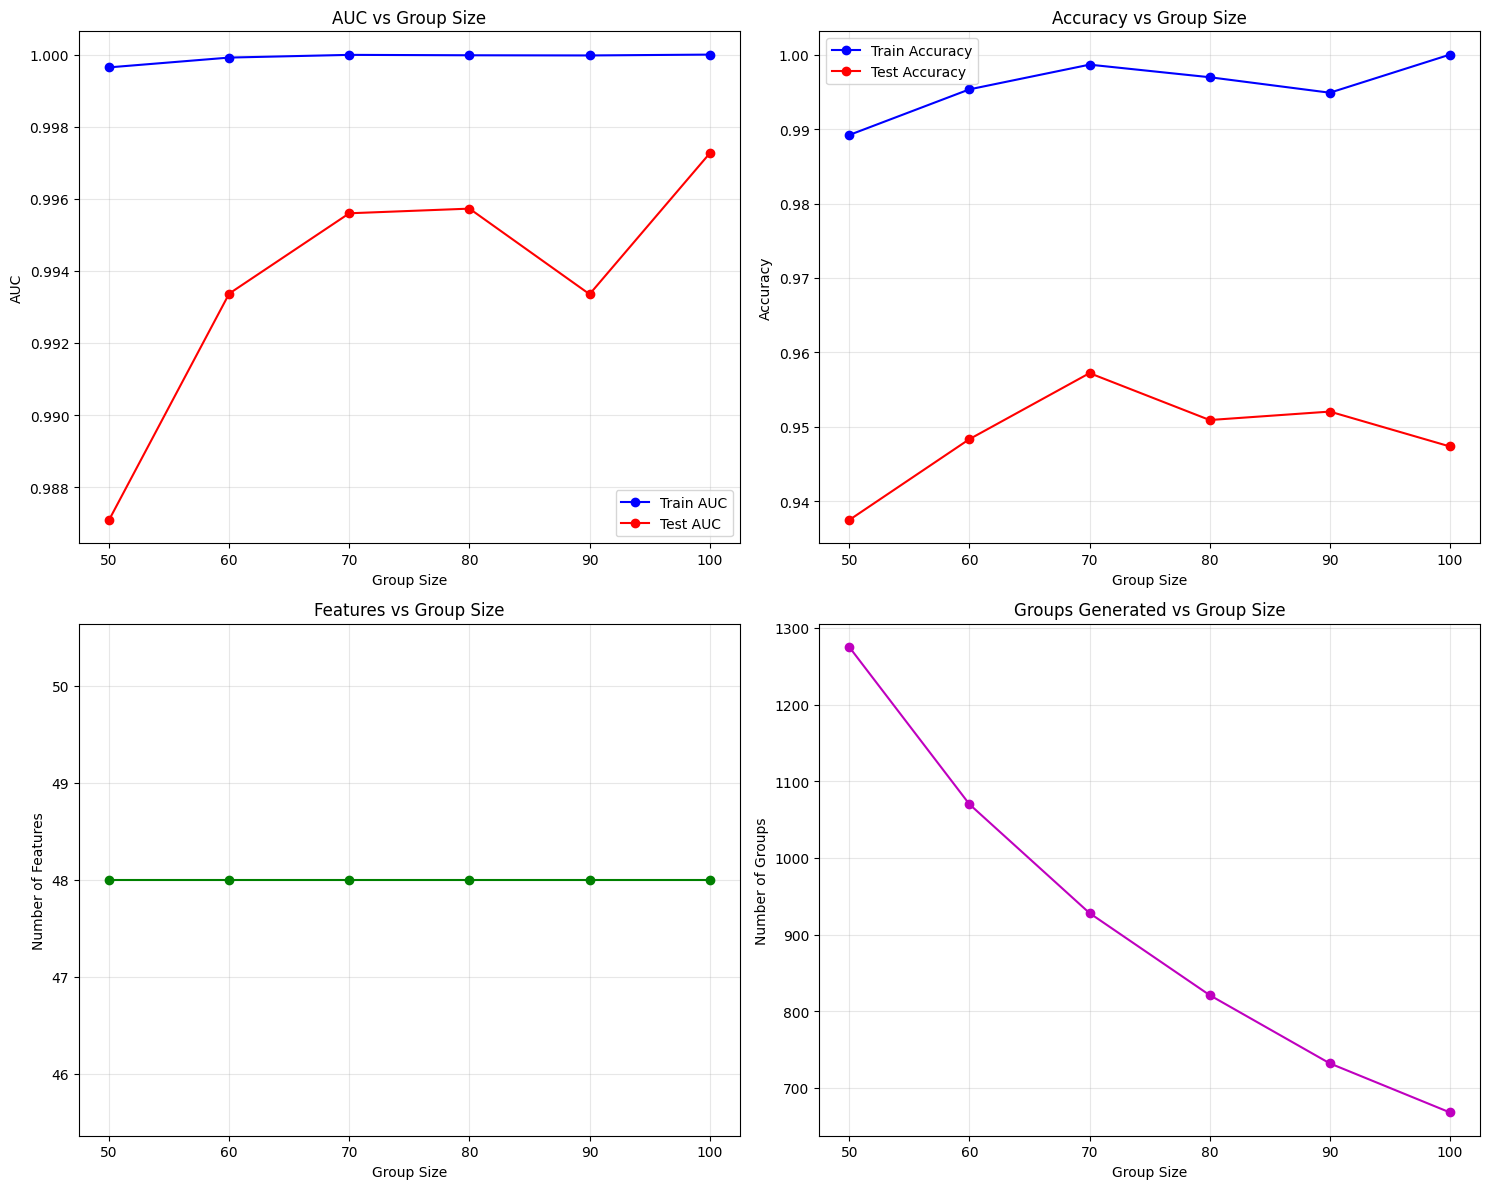


=== Optimal Configuration ===
Optimal group size: 100 neurons
Test AUC: 0.9973

All results saved to: D:\tabPFN
Analysis complete!


In [10]:
print("\n=== Generating Summary Results ===")

results_df = pd.DataFrame(results_summary)
results_df.to_csv(results_dir / "group_size_comparison.csv", index=False)

print("\nGroup Size Comparison Results:")
print(results_df.to_string(index=False))

# Comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# AUC
axes[0, 0].plot(results_df['group_size'], results_df['train_auc'], 'bo-', label='Train AUC')
axes[0, 0].plot(results_df['group_size'], results_df['test_auc'], 'ro-', label='Test AUC')
axes[0, 0].set_xlabel('Group Size'); axes[0, 0].set_ylabel('AUC')
axes[0, 0].set_title('AUC vs Group Size'); axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(results_df['group_size'], results_df['train_acc'], 'bo-', label='Train Accuracy')
axes[0, 1].plot(results_df['group_size'], results_df['test_acc'], 'ro-', label='Test Accuracy')
axes[0, 1].set_xlabel('Group Size'); axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Accuracy vs Group Size'); axes[0, 1].legend(); axes[0, 1].grid(True, alpha=0.3)

# Features
axes[1, 0].plot(results_df['group_size'], results_df['n_features'], 'go-')
axes[1, 0].set_xlabel('Group Size'); axes[1, 0].set_ylabel('Number of Features')
axes[1, 0].set_title('Features vs Group Size'); axes[1, 0].grid(True, alpha=0.3)

# Groups
axes[1, 1].plot(results_df['group_size'], results_df['n_groups'], 'mo-')
axes[1, 1].set_xlabel('Group Size'); axes[1, 1].set_ylabel('Number of Groups')
axes[1, 1].set_title('Groups Generated vs Group Size'); axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'group_size_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Optimal group size
optimal_idx = results_df['test_auc'].idxmax()
optimal_group_size = results_df.loc[optimal_idx, 'group_size']
optimal_auc = results_df.loc[optimal_idx, 'test_auc']

print(f"\n=== Optimal Configuration ===")
print(f"Optimal group size: {optimal_group_size} neurons")
print(f"Test AUC: {optimal_auc:.4f}")

# Save optimal info
optimal_info = {
    'optimal_group_size': int(optimal_group_size),
    'optimal_auc': float(optimal_auc),
    'model': 'TabPFN',
    'additional_data': 'QR19_QR23 included'
}

with open(results_dir / 'optimal_group_size.json', 'w') as f:
    json.dump(optimal_info, f, indent=2)

print(f"\nAll results saved to: {results_dir}")
print("Analysis complete!")